# Case Study: Compositional Inference for a Drift Diffusion Model

Consider a decision task in which participants are presented with sequences of letters and asked
to differentiate between words and non-words (i.e., a lexical decision task). The Diffusion Decision Model (DDM;
e.g., Ratcliff et al., 2016) simulataneously models this binary decision and the response time via a continuous evidence
accumulation process: After an initial non-decision time t0, evidence accumulates following a noisy diffusion process
with a certain drift rate ν, starting from a point β, until one of two decision thresholds {0,α}corresponding to the two
choices is hit.

\begin{align*}
\nu_j\sim\mathcal{N}(0.5,\exp(-1)) \\
\log \alpha_j\sim\mathcal{N}(0,\exp(-3)) \\
\log t_{0,j}\sim\mathcal{N}(-1,\exp(-1)) \\
\beta_j\sim\operatorname{Beta}(a=50,b=50) \\
y_j\sim \operatorname{DDM}(\nu_j,\alpha_j,t_{0,j},\beta_j)
\end{align*}
$\beta_\text{raw}$ is a transformed unbounded variable that is transformed to $\beta$ via the beta inverse CDF.


In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np

import matplotlib.pyplot as plt
import pickle

import keras
import bayesflow as bf

from ddm_simulator import simulate_ddm, beta_from_normal

problem_name = "compositional_case_study"
storage = '' #f'plots/{problem_name}/'
n_jobs = 10 #int(os.environ.get('SLURM_CPUS_PER_TASK', 1))

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
param_names = ['nu', 'log_alpha', 'log_t0', 'beta_raw']
pretty_param_names = [r'$\nu$', r'$\log \alpha$', r'$\log t_0$', r'$\beta_\text{raw}$']
num_training_batches = 256
num_validation_sets = 300
batch_size = 64
epochs = 1000

n_trials = 25

In [3]:
# ---------------------------
# Priors
# ---------------------------
def sample_priors():
    # Subject level
    nu = np.random.normal(0.5, np.exp(-1.0))
    log_alpha = np.random.normal(0.0, np.exp(-3.0))
    log_t0 = np.random.normal(-1.0, np.exp(-1.0))

    #beta = np.random.beta(a=50, b=50)
    beta_raw = np.random.normal(0.0, 1.0)
    beta = beta_from_normal(beta_raw, a=50, b=50)

    return {
        "nu": nu,
        "log_alpha": log_alpha,
        "alpha": np.exp(log_alpha),
        "log_t0": log_t0,
        "t0": np.exp(log_t0),
        "beta_raw": beta_raw,
        "beta": beta,
    }

def score_log_norm(x, m, s):
    return -(x - m) / s**2

def prior_score(x: dict):
    nu = x["nu"]
    log_alpha = x["log_alpha"]
    log_t0 = x["log_t0"]
    beta_raw = x["beta_raw"]

    parts = {
        "nu": score_log_norm(nu, m=0.5, s=np.exp(-1.0)),
        "log_alpha": score_log_norm(log_alpha, m=0.0, s=np.exp(-3.0)),
        "log_t0": score_log_norm(log_t0, m=-1.0, s=np.exp(-1.0)),
        "beta_raw":  score_log_norm(beta_raw, m=0.0, s=1.0)
    }
    return parts

simulator = bf.make_simulator([sample_priors, simulate_ddm])
print(simulator.sample(1)['sim_data'].shape)

(1, 2)


In [4]:
if os.path.exists(f"{storage}validation_data_single_trials.pkl"):
    with open(f'{storage}validation_data_single_trials.pkl', 'rb') as f:
        validation_data_trials = pickle.load(f)
    with open(f'{storage}validation_data_single_subjects.pkl', 'rb') as f:
        validation_data_subjects = pickle.load(f)
    try:
        with open(f'{storage}training_data_single_trials.pkl', 'rb') as f:
            training_data_trials = pickle.load(f)
        with open(f'{storage}training_data_single_subjects.pkl', 'rb') as f:
            training_data_subjects = pickle.load(f)
    except FileNotFoundError:
        training_data_trials = None
        training_data_subjects = None
        print("Training data not found")
else:
    training_data_trials = simulator.sample_parallel((num_training_batches * batch_size))
    validation_data_trials = simulator.sample_parallel(num_validation_sets)

    with open(f'{storage}training_data_single_trials.pkl', 'wb') as f:
        pickle.dump(training_data_trials, f)
    with open(f'{storage}validation_data_single_trials.pkl', 'wb') as f:
        pickle.dump(validation_data_trials, f)

    training_data_subjects = simulator.sample_parallel((num_training_batches * batch_size), n_trials=n_trials)
    validation_data_subjects = simulator.sample_parallel(num_validation_sets, n_trials=n_trials)

    with open(f'{storage}validation_data_single_subjects.pkl', 'wb') as f:
        pickle.dump(validation_data_subjects, f)
    with open(f'{storage}training_data_single_subjects.pkl', 'wb') as f:
        pickle.dump(training_data_subjects, f)

In [5]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .concatenate(param_names, into="inference_variables")
    .rename("sim_data", "inference_conditions")
)

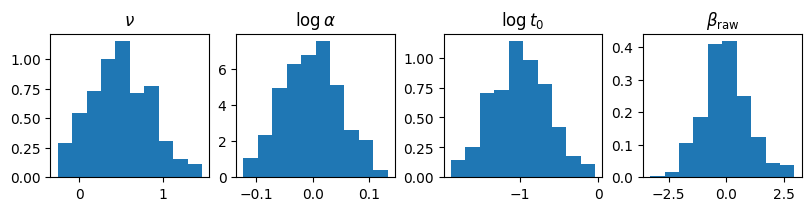

(300, 4)


In [6]:
# check how the distributions look like
test_params = adapter.forward(validation_data_trials)['inference_variables']
#test_params = adapter.forward(validation_data_subjects)['inference_variables']

n_rows = len(param_names) // 4
n_cols = int(np.ceil(len(param_names) / n_rows))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows), layout='constrained')
ax = ax.flatten()
for i, name in enumerate(pretty_param_names):
    samples = test_params[:, i]
    ax[i].hist(samples, density=True)
    ax[i].set_title(name)
plt.show()

print(test_params.shape)

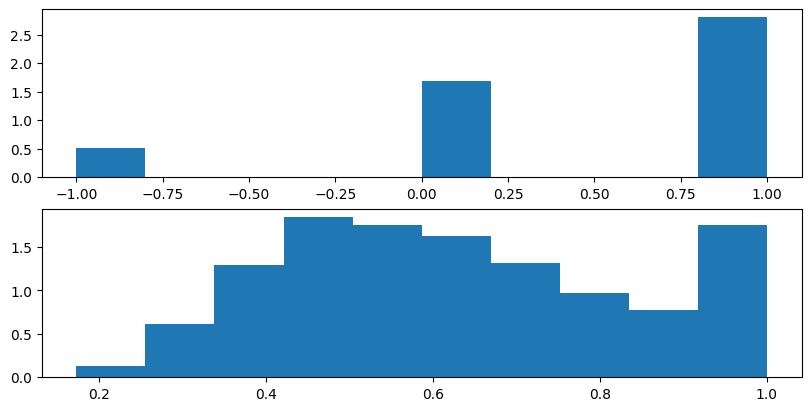

(300, 25, 2)


In [7]:
# check how the data distribution looks like (disable nan_to_num in adapter to see nans)
#test_data = adapter.forward(validation_data_trials)['inference_conditions']
test_data = adapter.forward(validation_data_subjects)['inference_conditions']
n_features = test_data.shape[-1]

fig, ax = plt.subplots(nrows=2, ncols=int(np.ceil(n_features / 2)), figsize=(8, 4), layout='constrained')
ax = ax.flatten()
for i in range(n_features):
    ax[i].hist(test_data[..., i].flatten(), density=True)
plt.show()

print(test_data.shape)

# No Pooling
 trained on single trials, compositional inference over trials for the same subject

In [8]:
workflow_trials = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=bf.networks.DiffusionModel(),
)

In [9]:
model_path = f'{storage}no_pooling_single_trial.keras'
if not os.path.exists(model_path):
    history = workflow_trials.fit_offline(
        training_data_trials,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data_trials,
        verbose=2,
    )
    workflow_trials.approximator.save(model_path)
else:
    workflow_trials.approximator = keras.models.load_model(model_path)

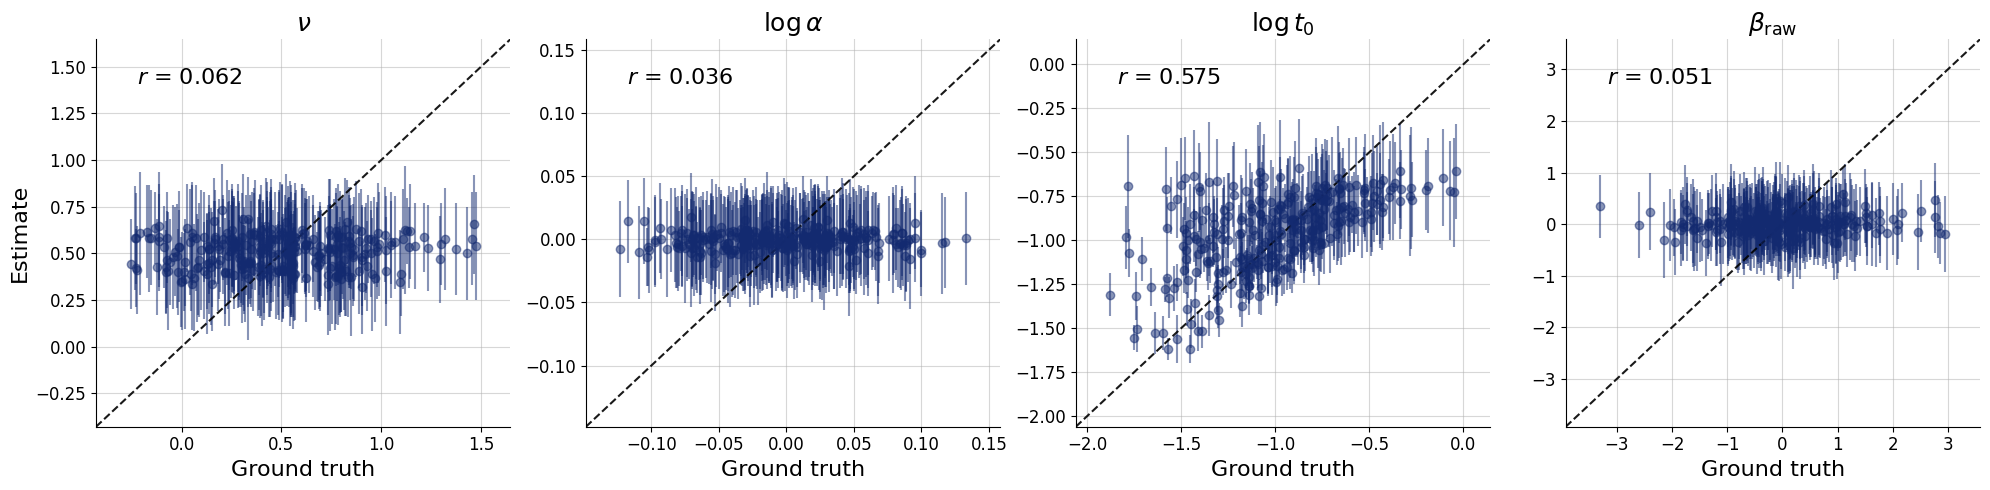

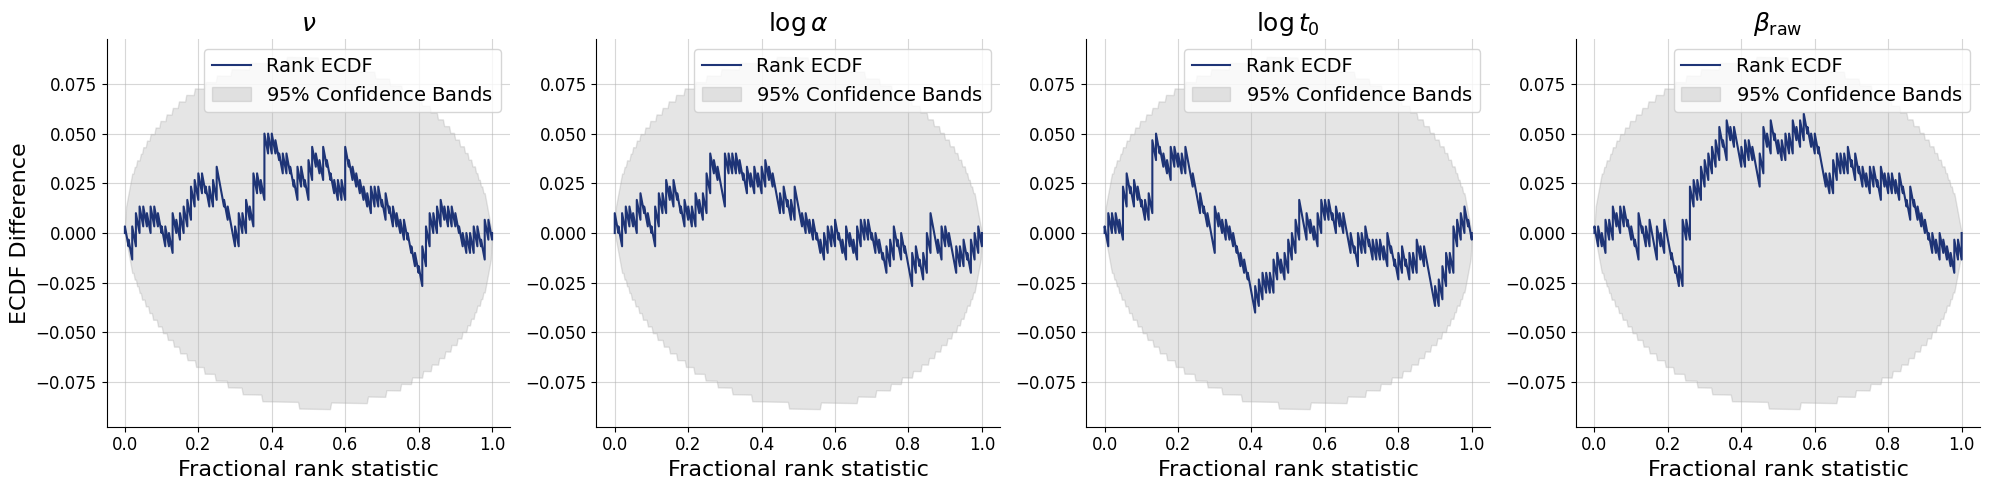

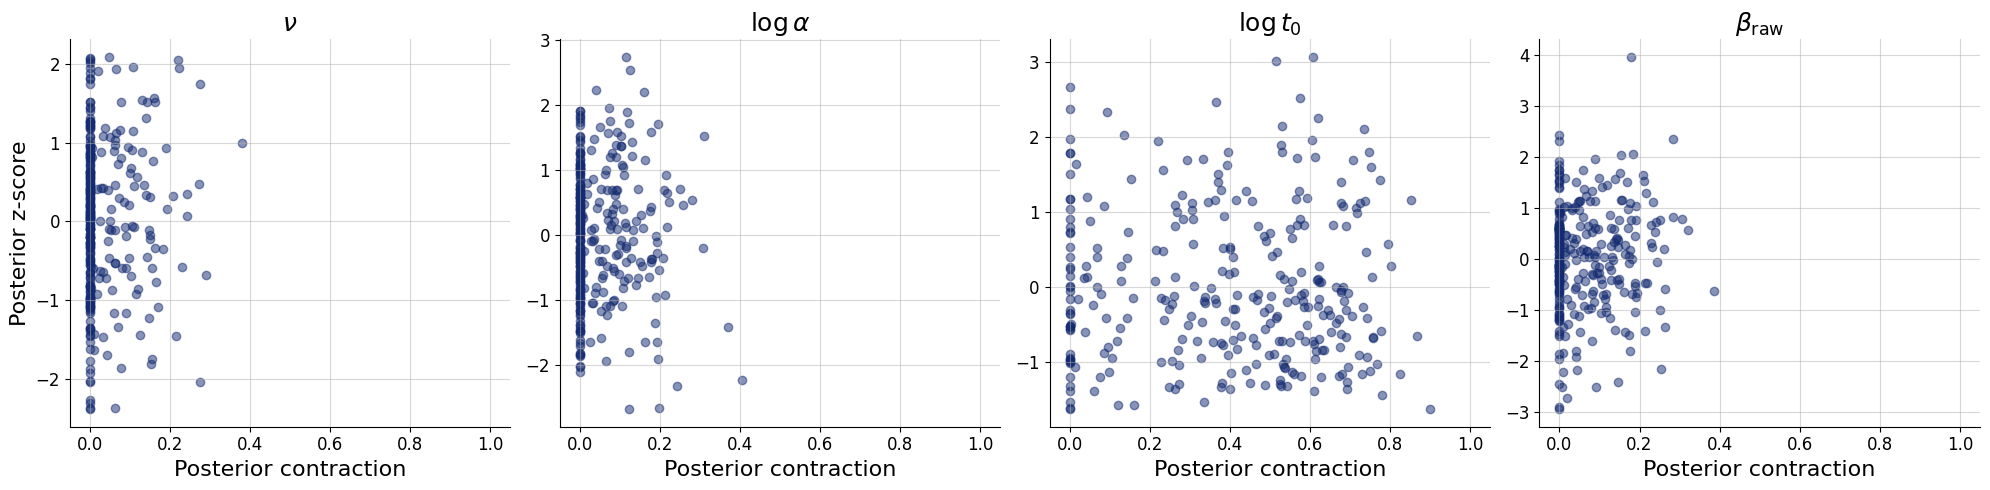

In [10]:
diagnostics_plots = workflow_trials.plot_default_diagnostics(test_data=validation_data_trials, num_samples=100,
                                                             calibration_ecdf_kwargs={"difference": True},
                                                             variable_names=pretty_param_names)
for k in diagnostics_plots.keys():
    diagnostics_plots[k].savefig(f"{storage}no_pooling_single_trial_{k}.png")

## Compositional inference over trials

In [12]:
test_data_comp_trials = simulator.sample_parallel(300, n_trials=n_trials)
validation_data_trials['sim_data'].shape, test_data_comp_trials['sim_data'].shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished


((300, 2), (300, 25, 2))

In [16]:
workflow_trials.approximator.inference_network.integrate_kwargs = {'method': 'euler_maruyama',
                                                                   'steps': 300,
                                                                   #'corrector_steps': 3,
                                                                   #'step_size_factor': 0.01,
                                                                   'mini_batch_size': 1,
                                                                   #'compositional_d1': 0.05,
                                                                   }

In [17]:
test_posterior_comp_trials = workflow_trials.compositional_sample(num_samples=100,
                                                                  conditions={'sim_data': test_data_comp_trials['sim_data']},
                                                                  compute_prior_score=prior_score)

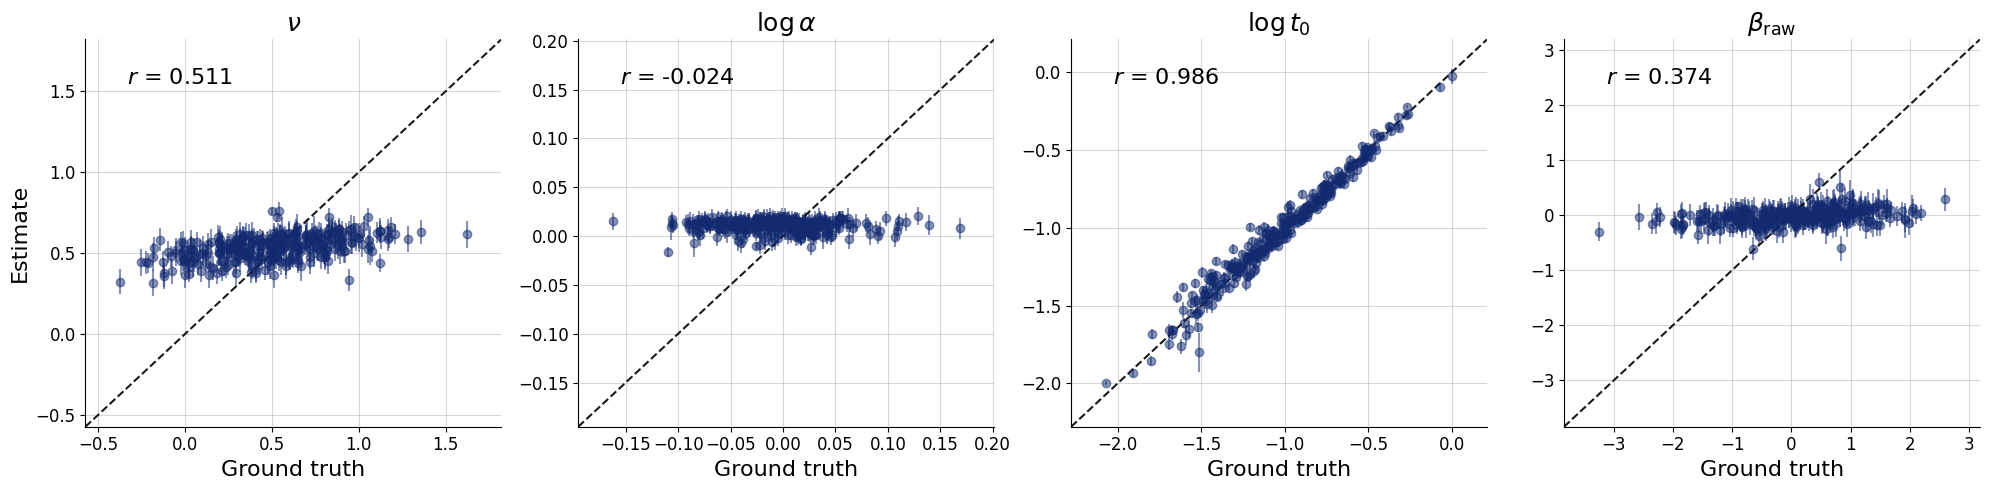

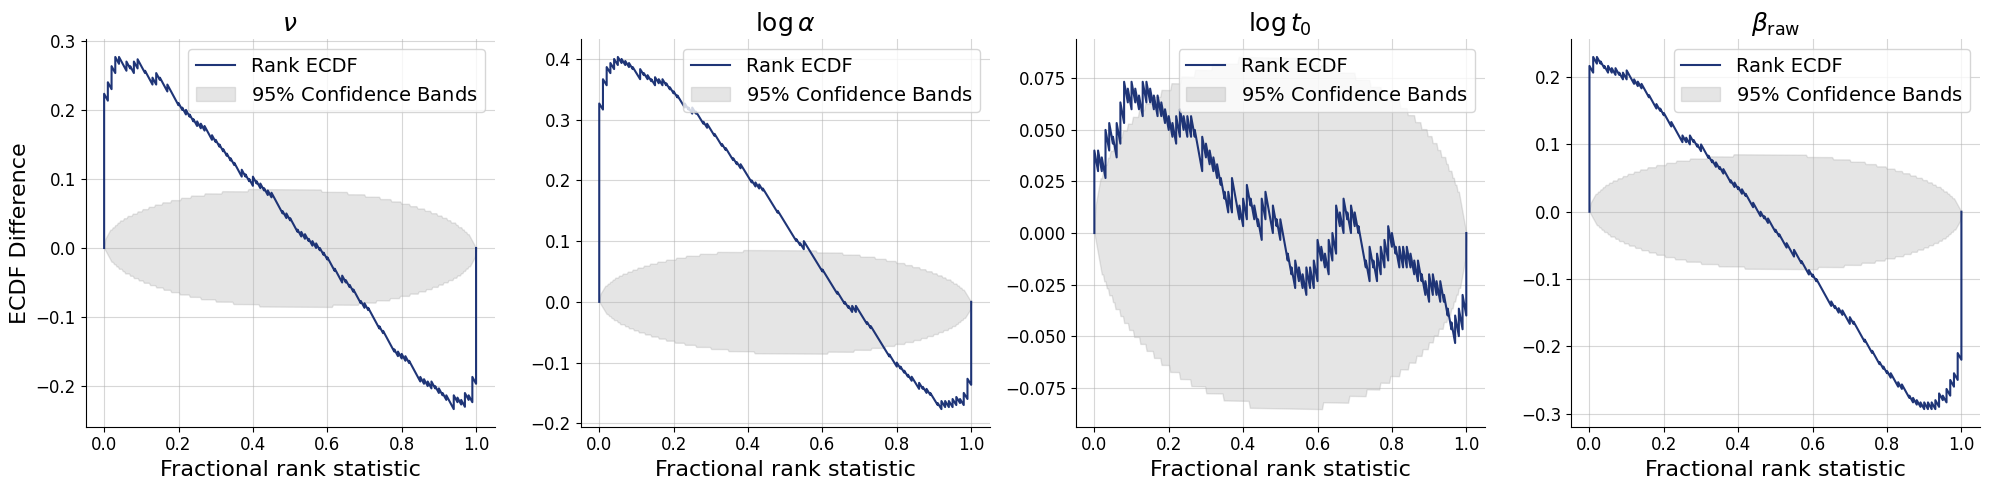

In [18]:
fig = bf.diagnostics.recovery(
    estimates=test_posterior_comp_trials,
    targets=test_data_comp_trials,
    variable_names=pretty_param_names
)
fig.savefig(f"{storage}no_pooling_compositional_trials_recovery.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=test_posterior_comp_trials,
    targets=test_data_comp_trials,
    difference=True,
    variable_names=pretty_param_names
)
fig.savefig(f"{storage}no_pooling_compositional_trials_calibration.png")

## Training on multiple trials per subject
trained on single subjects (multiple trials)

In [19]:
adapter_subjects = (
    bf.adapters.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    .concatenate(param_names, into="inference_variables")
    .rename("sim_data", "summary_variables")
)

In [20]:
workflow_subjects = bf.BasicWorkflow(
    adapter=adapter_subjects,
    summary_network=bf.networks.SetTransformer(summary_dim=16, dropout=0.1),
    inference_network=bf.networks.DiffusionModel(),
)

In [21]:
model_path = f'{storage}no_pooling_single_subject.keras'
if not os.path.exists(model_path):
    history = workflow_subjects.fit_offline(
        training_data_subjects,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data_subjects,
        verbose=2,
    )
    workflow_subjects.approximator.save(model_path)
else:
    workflow_subjects.approximator = keras.models.load_model(model_path)

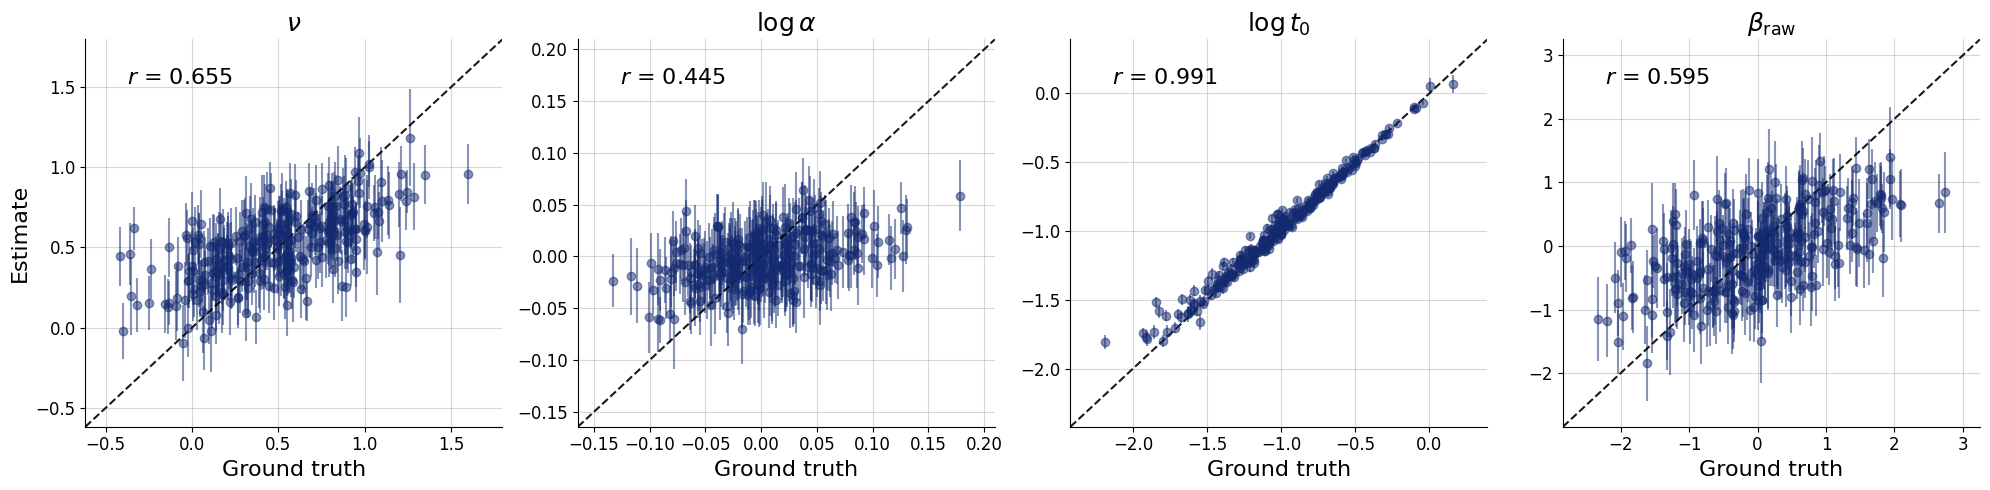

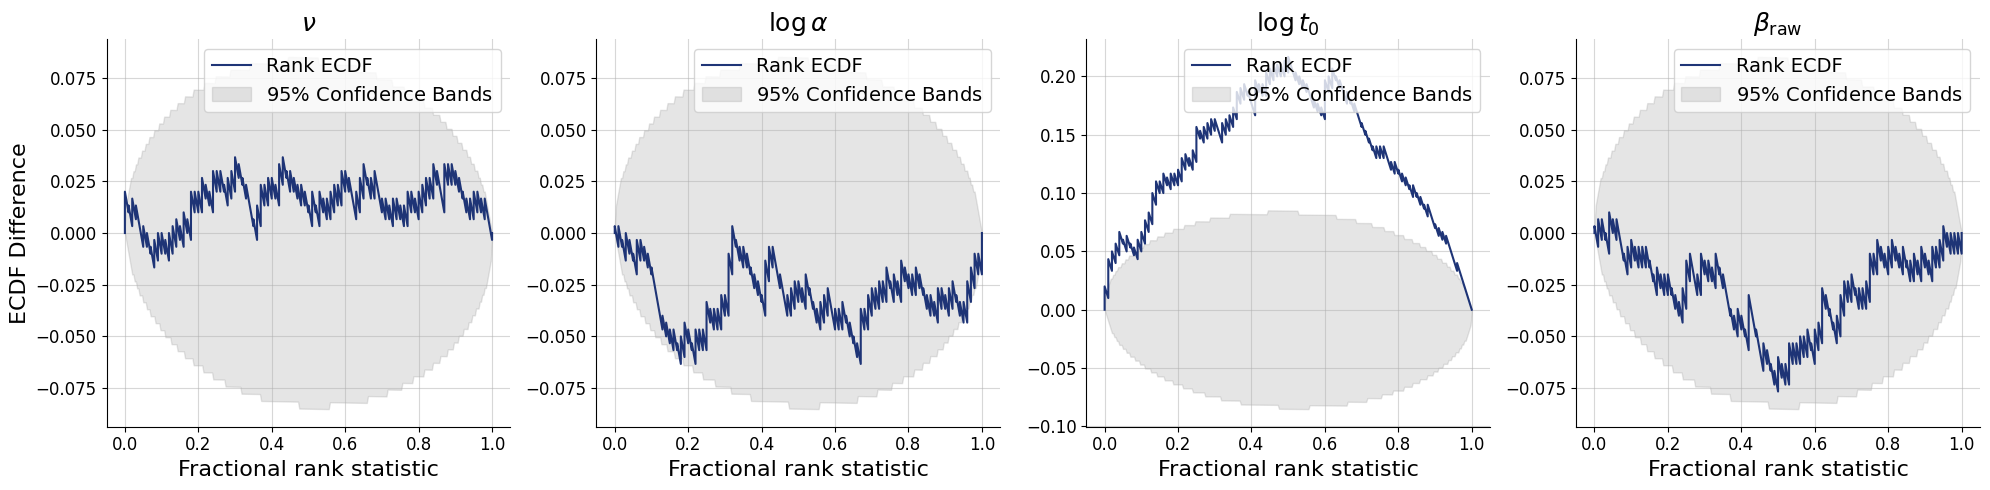

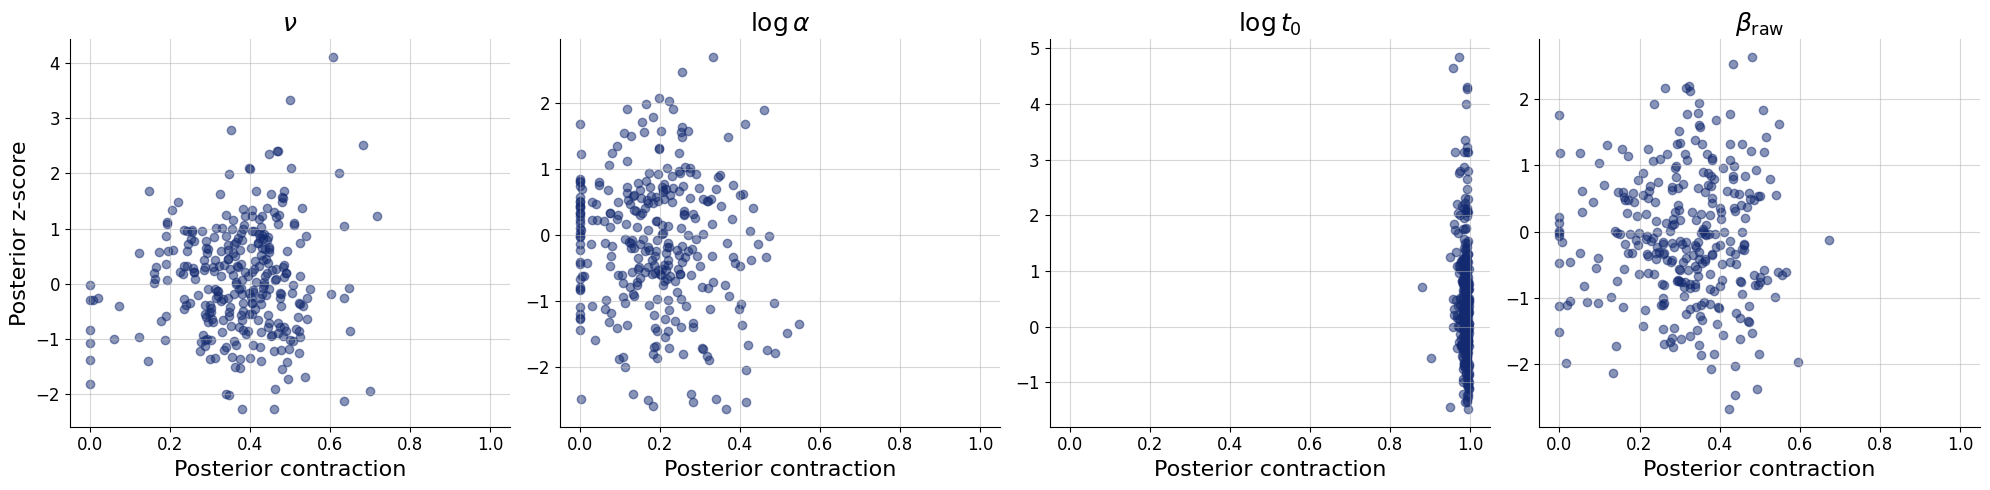

In [22]:
diagnostics_plots = workflow_subjects.plot_default_diagnostics(test_data=validation_data_subjects, num_samples=100,
                                                               calibration_ecdf_kwargs={"difference": True},
                                                               variable_names=pretty_param_names)
for k in diagnostics_plots.keys():
    diagnostics_plots[k].savefig(f"{storage}no_pooling_single_subject_{k}.png")

# Complete Pooling

## Compositional inference over trials and subjects

In [24]:
test_data_comp_subjects_trials = simulator.sample_parallel(100, n_subjects=30, n_trials=n_trials)
test_data_comp_subjects_trials['sim_data'] = test_data_comp_subjects_trials['sim_data'].reshape(100, 30*n_trials, 2)
validation_data_trials['sim_data'].shape, test_data_comp_subjects_trials['sim_data'].shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


((300, 2), (100, 750, 2))

In [36]:
workflow_trials.approximator.inference_network.integrate_kwargs = {'method': 'euler_maruyama',
                                                                   'steps': 500,
                                                                   'corrector_steps': 1,
                                                                   #'step_size_factor': 0.01,
                                                                   'mini_batch_size': 1,
                                                                   'compositional_bridge_d1': 0.001,
                                                                   'compositional_bridge_d0': 0.1,
                                                                   }

In [37]:
test_posterior_comp_subjects_trials = workflow_trials.compositional_sample(num_samples=100,
                                                                           conditions={'sim_data': test_data_comp_subjects_trials['sim_data']},
                                                                           compute_prior_score=prior_score)

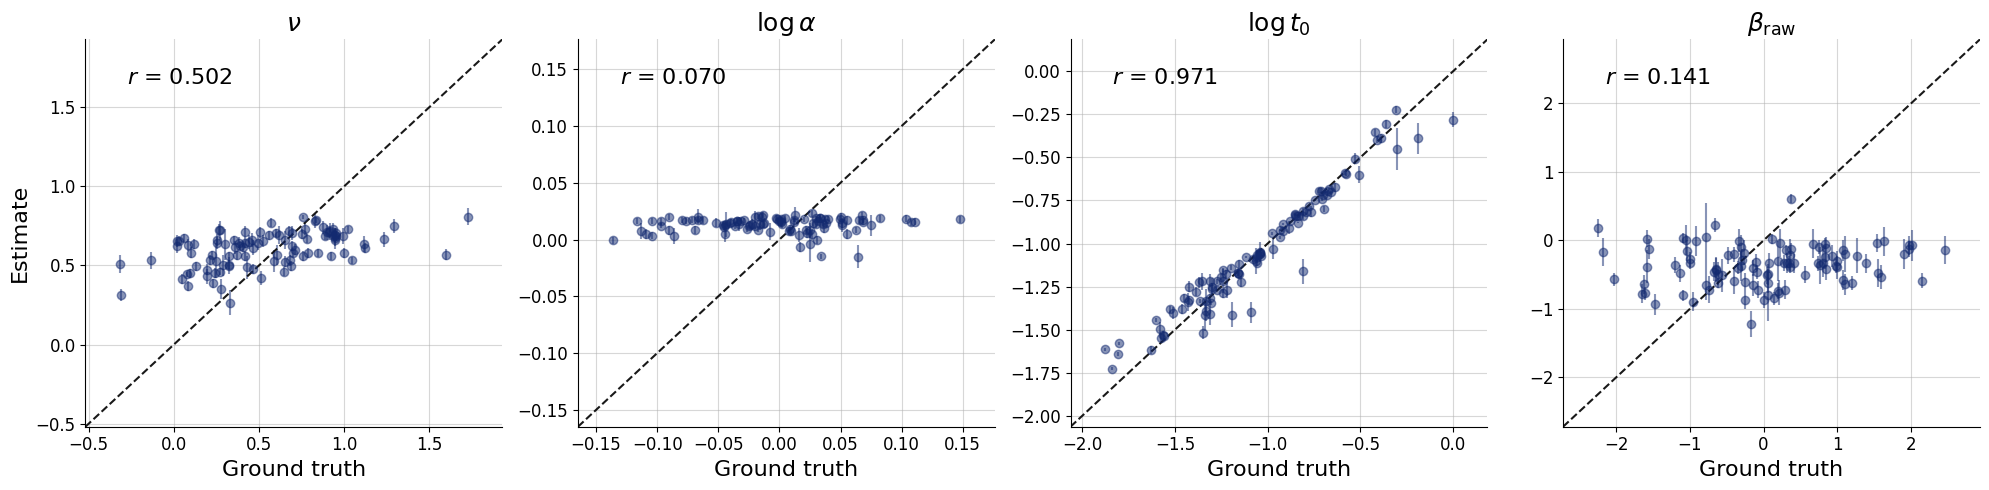

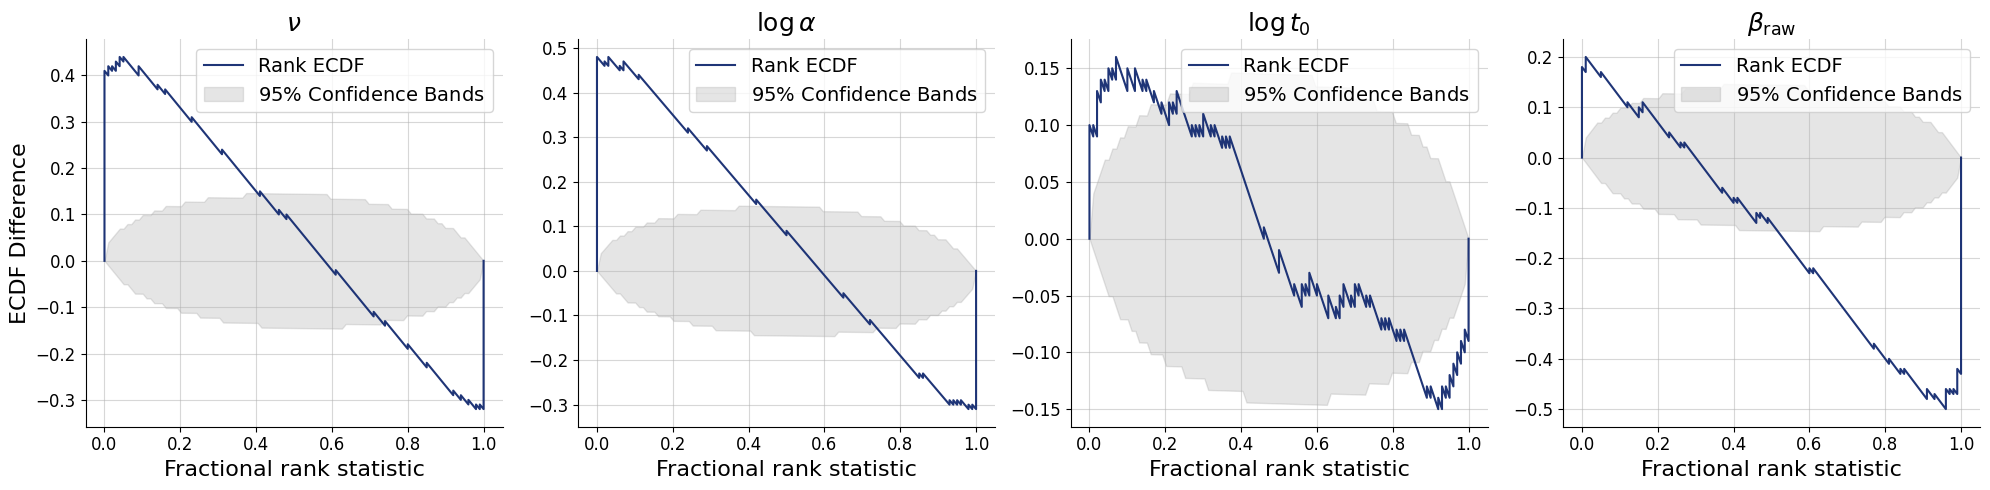

In [38]:
fig = bf.diagnostics.recovery(
    estimates=test_posterior_comp_subjects_trials,
    targets=test_data_comp_subjects_trials,
    variable_names=pretty_param_names
)
fig.savefig(f"{storage}no_pooling_compositional_subjects_trials_recovery.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=test_posterior_comp_subjects_trials,
    targets=test_data_comp_subjects_trials,
    difference=True,
    variable_names=pretty_param_names
)
fig.savefig(f"{storage}no_pooling_compositional_subjects_trials_calibration.png")

## Compositional inference over subjects

In [40]:
test_data_comp_subjects = simulator.sample_parallel(100, n_subjects=30, n_trials=n_trials)
validation_data_subjects['sim_data'].shape, test_data_comp_subjects['sim_data'].shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


((300, 25, 2), (100, 30, 25, 2))

In [43]:
workflow_subjects.approximator.inference_network.integrate_kwargs = {'method': 'euler_maruyama',
                                                                   'steps': 300,
                                                                   'corrector_steps': 1,
                                                                   #'step_size_factor': 0.01,
                                                                   'mini_batch_size': 1,
                                                                   #'compositional_bridge_d1': 0.001,
                                                                   #'compositional_bridge_d0': 0.1,
                                                                   }

In [44]:
test_posterior_comp_subjects = workflow_subjects.compositional_sample(num_samples=100,
                                                                      conditions={'sim_data': test_data_comp_subjects['sim_data']},
                                                                      compute_prior_score=prior_score)

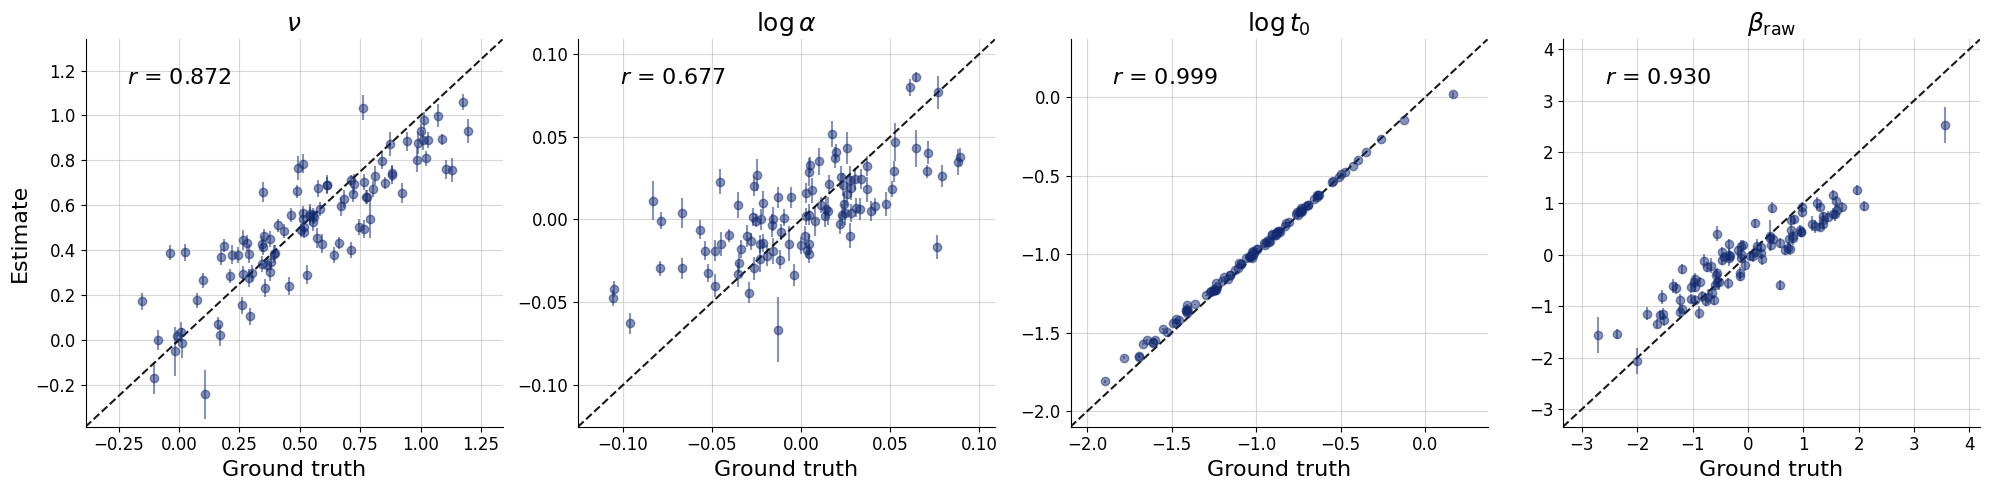

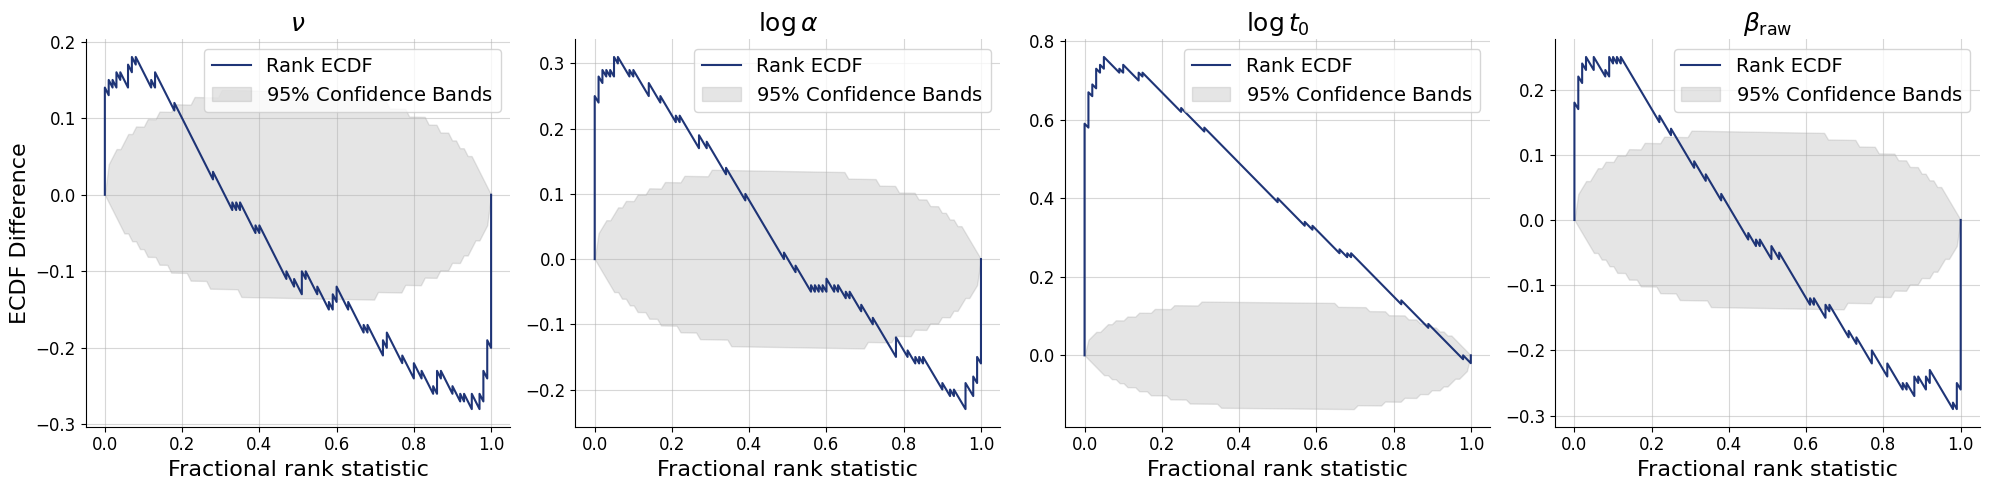

In [45]:
fig = bf.diagnostics.recovery(
    estimates=test_posterior_comp_subjects,
    targets=test_data_comp_subjects,
    variable_names=pretty_param_names
)
fig.savefig(f"{storage}complete_pooling_compositional_subjects_recovery.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=test_posterior_comp_subjects,
    targets=test_data_comp_subjects,
    difference=True,
    variable_names=pretty_param_names
)
fig.savefig(f"{storage}complete_pooling_compositional_subjects_calibration.png")